# Cross-validation of GefCOM2014

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import deep4cast.models as models
import deep4cast.cv as cv

from deep4cast.forecasters import Forecaster
from deep4cast.cv import FoldGenerator, VectorScaler, MetricsEvaluator, CrossValidator
from skopt.space import Real, Integer, Categorical

%matplotlib inline

Using TensorFlow backend.


# Parameters

In [8]:
horizon = 24
lag = 2*horizon
filters=64
num_layers=2
lr=0.001
epochs=10
test_fraction = 0.1
n_folds=1

# Load the data from file
df = pd.read_pickle('../data/processed/gefcom2014-e.pkl')

# Data exploration

AttributeError: 'AxesSubplot' object has no attribute 'flat'

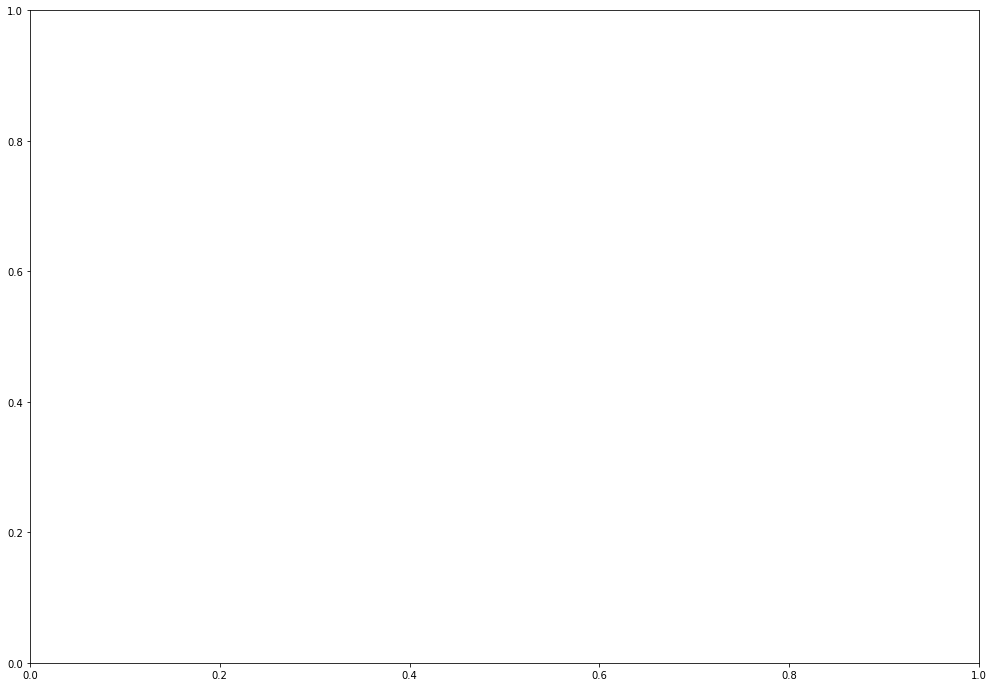

In [3]:
# Let plot the target time series data folds that will be used for temporal cross-validation
test_length = int(len(df)*test_fraction)
train_length = len(df) - n_folds*test_length

fig, axes = plt.subplots(nrows=n_folds, ncols=1, sharex=True, figsize=(17, 12))
for ax, i in zip(axes.flat, range(n_folds)):
    x_train = df.index[i*test_length:i*test_length+train_length]
    y_train = df.load[i*test_length:i*test_length+train_length]
    x_test = df.index[i*test_length+train_length:(i+1)*test_length+train_length]
    y_test = df.load[i*test_length+train_length:(i+1)*test_length+train_length]
    x_all = df.index
    y_all = df.load
    ax.plot(x_all, y_all, 'k-', alpha=0.15)
    ax.plot(x_train, y_train, 'b-', alpha=0.65)
    ax.plot(x_test, y_test, 'r-')
    ax.plot([min(x_test), min(x_test)], [2000, 5500], 'k-')
    ax.plot([max(x_test), max(x_test)], [2000, 5500], 'k-')
    ax.set_ylim([2000, 5500])
    ax.set_xlim([min(x_all), max(x_all)])
    ax.set_ylabel('Load')
plt.xlabel('Time (hours)')
plt.show()
plt.tight_layout()

# Print the number of training, validation, and testing time steps
print(
    'Training fraction: {}\nTesting fraction: {}\nTraining data points: {}\nTesting data points: {}'.format(
    round((1-n_folds*test_fraction), 3), 
    round(test_fraction, 3),
    int(len(df)*(1-n_folds*test_fraction)), 
    int(len(df)*test_fraction)
))

# Data preparation

In [4]:
# Loading the dataset and dropping unncecessary columns
data = df.drop(['time', 'month', 'day', 'hour'], axis=1)
data = data.dropna()

# We have real-valued and categorial features and we need to make sure that we do the data 
# preparation for them correctly
real_values = ['load', 'temperature']
categorical = list(set(data.columns).difference(set(real_values)))

# # Let's create shifted categorical feature to include information about the future's holiday 
# # structure. This will make it easier for our model to do predictions on holidays
# shifted = data[categorical].shift(-horizon)
# shifted = shifted.rename(columns={column:column + '_shifted' for column in shifted.columns})
# data = pd.concat([data, shifted], axis=1)

# Format data into numpy array
data = np.expand_dims(data.values, 0)

# Model

In [5]:
# forecaster and model setup
model = models.WaveNet(filters=filters, num_layers=num_layers)
forecaster = Forecaster(model, lag=lag, horizon=horizon, lr=lr, epochs=epochs)

# build a fold generator
fold_generator = FoldGenerator(
    data=data, 
    targets=[0], 
    lag=lag, 
    horizon=horizon, 
    test_fraction=test_fraction, 
    n_folds=n_folds
)

# ... and an evaluator
evaluator = MetricsEvaluator(
    metrics = ['smape', 'pinball_loss', 'coverage'], 
    filename='test.pkl'
)

# ... and a data scaler
scaler = VectorScaler(targets = [0, 1])

# ... and a cross-validator
validator = CrossValidator(forecaster, fold_generator, evaluator, scaler)

# Cross Validation

In [9]:
# Evaluate on the cross-validation folds
metrics = validator.evaluate(verbose=False)

# Evaluation

   smape  pinball_loss                                           coverage
0  14.06       3835.52  ([7.650659133709981, 15.842749529190206, 31.66...
1  12.58       3214.60  ([0.0, 4.119585687382298, 24.31732580037665, 4...


Text(0,0.5,'Prediction quantile')

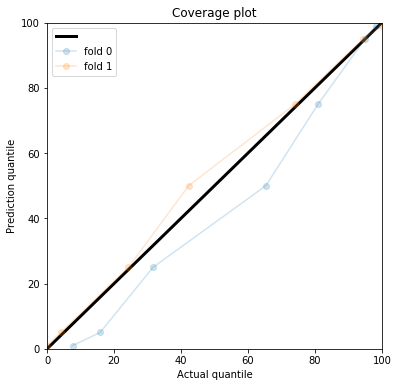

In [11]:
# Let's look at the cross-validation results
print(metrics)

# Plot probability calibration plots
x = [1, 5, 25, 50, 75, 95, 99]
coverages = metrics.iloc[:-2,-7:]
plt.figure(figsize=(6, 6))
plt.plot([0] + x + [100], [0] + x + [100], 'k-', linewidth=3)
for cov_x, cov_y in metrics.coverage:
    plt.plot(cov_x, cov_y, 'o-', alpha=0.2)
plt.legend([''] + ['fold ' + str(s) for s in np.arange(n_folds)])
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.title('Coverage plot')
plt.xlabel('Actual quantile')
plt.ylabel('Prediction quantile')

# Optimization

In [10]:
space  = [Categorical([32, 64, 128, 256, 512, 1024], name='filters'),
          Integer(1, 8, name='num_layers'),
          Integer(24, 4*24, name='lag'),
          Real(10**-6, 10**-3, "log-uniform", name='lr')]

opt_results = validator.optimize(space, 'pinball_loss', n_calls=100)

{'filters': 256, 'num_layers': 7, 'lag': 86, 'lr': 0.0003481410351917474}


KeyboardInterrupt: 